In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Load training and validation sets
train_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_aug_data,
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.25,
    subset="training",
    seed=123,
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_aug_data,
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.25,
    subset="validation",
    seed=123,
)

# Store class names for use in classification report and confusion matrix
class_names = train_data.class_names

# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
validation_data = validation_data.map(lambda x, y: (normalization_layer(x), y))

# Cache and prefetch
train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)



Found 1300 files belonging to 2 classes.
Using 975 files for training.
Found 1300 files belonging to 2 classes.
Using 325 files for validation.


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load ResNet50 model pre-trained on ImageNet, excluding the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to prevent updating pre-trained weights during initial training
base_model.trainable = False

# Add custom layers on top for binary classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=3
)


Epoch 1/3
31/31 ━━━━━━━━━━━━━━━━━━━━ 251s 8s/step - accuracy: 0.5841 - loss: 0.6826 - val_accuracy: 0.5969 - val_loss: 0.6614
Epoch 2/3
31/31 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step - accuracy: 0.5938 - loss: 0.6758 - val_accuracy: 0.6185 - val_loss: 0.6455
Epoch 3/3
31/31 ━━━━━━━━━━━━━━━━━━━━ 237s 8s/step - accuracy: 0.6121 - loss: 0.6547 - val_accuracy: 0.6092 - val_loss: 0.6376


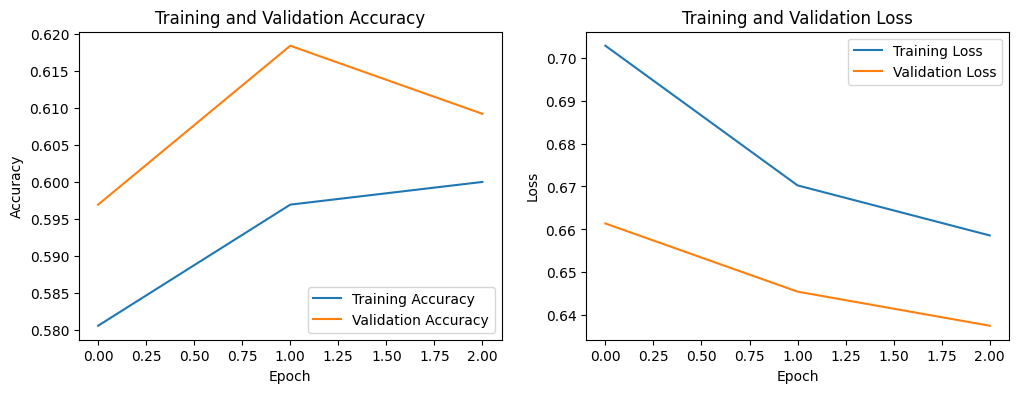

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
Confusion Matrix:
[[194   0]
 [127   4]]
Classification Report:
              precision    recall  f1-score   support

   def_front       0.60      1.00      0.75       194
    ok_front       1.00      0.03      0.06       131

    accuracy                           0.61       325
   macro avg       0.80      0.52      0.41       325
weighted avg       0.76      0.61      0.47       325



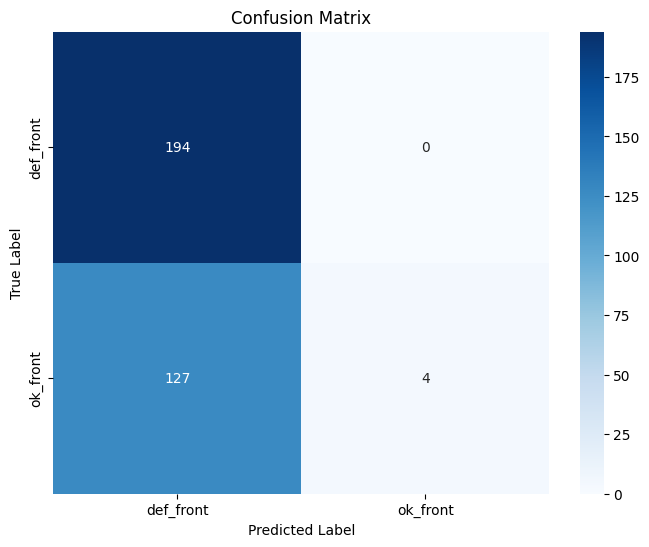

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the validation set
y_true = []
y_pred = []

for images, labels in validation_data:
    # Store true labels
    y_true.extend(labels.numpy())

    # Predict and store predicted labels
    predictions = model.predict(images)
    y_pred.extend(np.round(predictions).flatten())  # Round for binary classification

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
